# Impact of variable lookups on working memory

This experiment evalutes the impact of remembering variable <-> value mappings in mentally computing arithmetic expressions. The participant is repeatedly provided expressions like:

```
x = 1
y = 1

x - 2 + y + 4 - 1 - y + y + x
```

The response is measured for duration and correctness. Specifically, we generate arithmetic expressions with 4 variable lookups, 4 constants, and 7 binary operations (either addition or subtraction). In each condition, the number of unique variables is varied from 1 to 8 (the example above has 2 unique variables). Each condition was run 10 times on a random expression with only Will as the participant.

**Hypothesis:** the average duration should increase nonlinearly with the number of variables in the expression due to working memory load in looking up variables.

In [3]:
from IPython.core.display import display, HTML, clear_output
from code_diff import Code
import ipywidgets as widgets
from timeit import default_timer as now
import random
from random import choice, randint
import ast
import showast
import astor
import pandas as pd
from scipy.stats import f_oneway
a2s = astor.to_source

# Method
This code implements the expression generation and experiment UI.

In [7]:
class Expr:
    def __init__(self, assignments, expr, params):
        self.assignments = assignments
        self.expr = expr
        self.params = params
        
    def to_string(self):
        return '\n'.join(self.assignments), ' '.join(self.expr)[:-1]
    
    def eval_expr(self):
        ctx, expr = self.to_string()
        ctx2 = '\n\t'.join(ctx.split('\n'))
        exec(f'def p():\n\t{ctx2}\n\treturn {expr}\nret = p()', globals())
        return ret 

In [8]:
class ExprGenerator:
    def __init__(self, cnst_count, vr_count):
        self.vrs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        self.cnst_count = cnst_count
        self.vr_count = vr_count
        self.ops = ['+', '-']
        
    def gen(self, distinct_vrs):
        random.shuffle(self.vrs)
        vrs = self.vrs[:distinct_vrs]
        vr_assgn = [f'{vr} = {randint(1, 8)}' for vr in vrs]        
        assert self.vr_count >= distinct_vrs
        values = vrs + [choice(vrs) for _ in range(self.vr_count - distinct_vrs)] \
            + [randint(1, 8) for _ in range(self.cnst_count)]
        random.shuffle(values)
        expr = [f'{v} {choice(self.ops)}' for v in values]
        assign_str = '\n'.join(vr_assgn)
        expr_str = ' '.join(expr)[:-1]
        return Expr(vr_assgn, expr, 
                    {'cnst_count': self.cnst_count, 'vr_count': self.vr_count, 'distinct_vrs': distinct_vrs})

In [9]:
def tracing_test(expr, results):    
    ctx_str, expr_str = expr.to_string()
    next_btn = widgets.Button(description='Next')

    def on_next(_):
        clear_output()
    
        start = now()
        entry = widgets.Text(placeholder='Answer here...')

        def on_submit(_):
            duration = now() - start
            value = entry.value
            results.append({
                'expr': expr,
                'guess': value, 
                'duration': duration
            })
            clear_output()

        entry.on_submit(on_submit)
    
        code = f'{ctx_str}\n\n{expr_str}'
        display(Code(code=code))
        display(widgets.HTML('Compute the value of the expression above.'))
        display(entry)
        
    next_btn.on_click(on_next)
    display(Code(code=ctx_str))
    display(next_btn)

In [10]:
results = []

In [14]:
expr = ExprGenerator(cnst_count=4, vr_count=4).gen(distinct_vrs=1)
tracing_test(expr, results)

Code(code='d = 8\n\n8 + 6 + d - 4 + d + d + d + 5 ')

HTML(value='Compute the value of the expression above.')

Text(value='', placeholder='Answer here...')

In [209]:
onevar_results = results

In [12]:
fourvar_results = []

In [13]:
expr = ExprGenerator(cnst_count=4, vr_count=4).gen(distinct_vrs=4)
tracing_test(expr, fourvar_results)

Code(code='a = 6\nd = 7\nb = 3\nc = 3\n\n1 - b - 8 + c - 3 + a + 4 - d ')

HTML(value='Compute the value of the expression above.')

Text(value='', placeholder='Answer here...')

In [225]:
twovar_results = []

In [240]:
expr = ExprGenerator(cnst_count=4, vr_count=4).gen(distinct_vrs=2)
tracing_test(expr, twovar_results)

In [286]:
def to_df(res, nv):
    for r in res:
        r['answer'] = r['expr'].eval_expr()
        r['correct'] = 1. if r['answer'] == int(r['guess']) else 0.
        r['distinct_vrs'] = nv
    return pd.DataFrame(res).drop('expr', 1)

In [287]:
all_results = {1: onevar_results, 2: twovar_results, 4: fourvar_results}
all_results = [to_df(v, k) for k, v in all_results.items()]

In [288]:
result_df = pd.concat(all_results)

# Results

The results are shown below. `duration` is the time to complete the task, and `correct` is `1` if correct and `0` if incorrect. `distinct_vrs` is the unique number of variables. Below is the per-treatment mean of each measurement. Findings:

* The average duration for the 4 variable condition appears significantly higher than 1 or 2, suggesting that there is a non-linear increase in mental work consistent with high load on working memory.
* The mean correctness also significantly decreases in the 4 variable case.

In [363]:
result_df.groupby('distinct_vrs').mean()

,duration,answer,correct
distinct_vrs,,,
1,11.060034,3.8,0.9
2,10.910329,2.9,0.9
4,15.892765,7.7,0.6


Looking at the durations graphically, we can see that the distribution of duration is significantly different from the other two conditions.

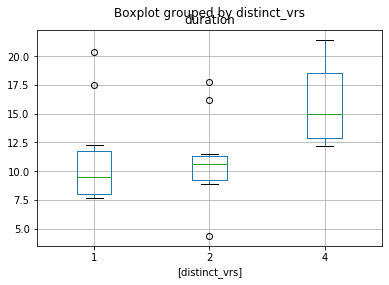

In [310]:
result_df.boxplot('duration', by=['distinct_vrs'])